In [25]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import statsmodels.api as sm
import numpy as np


In [2]:
df_net = pd.read_csv(
    "project/dataset/Original/global/global-genre_network-2019.csv",
    sep="\t"
)

df_net.head()


,source,target,weight,avg_streams
0,latin,reggaeton,479,1.060468e+08
1,latin,latin,282,1.048953e+08
2,pop rap,rap,222,5.385630e+07
3,rap,trap,218,6.656220e+07
4,hip hop,rap,203,5.405006e+07


- source = first genre,
- target = second genre,
- weight = how many successful collaborations exist between them
- avg_streams = average number of streams for tracks using this pair

we need to remove self-loops because we focus on collaboration, so latin-> latin cannot exist

In [3]:
df_net = df_net[df_net["source"] != df_net["target"]]


#### Data Validation

In [ ]:
print("Missing values:")
print(df_net.isnull().sum())

print("\nDuplicate rows:", df_net.duplicated().sum())

print("\nBasic stats:")
print(df_net[["weight","avg_streams"]].describe())


Missing values:
source         0
target         0
weight         0
avg_streams    0
dtype: int64

Duplicate rows: 0

Basic stats:
            weight   avg_streams
count  2854.000000  2.854000e+03
mean      5.197267  5.646152e+07
std      17.602874  6.721066e+07
min       1.000000  4.104898e+06
25%       1.000000  1.265128e+07
50%       2.000000  3.300360e+07
75%       3.000000  8.051185e+07
max     479.000000  7.286733e+08


# Building network

In [5]:
G = nx.from_pandas_edgelist(
    df_net,
    source="source",
    target="target",
    edge_attr=["weight", "avg_streams"]
)

### Analysis

1. Shows how many genres exist and how many collaborations between genres are observed.

In [6]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())
print("Density:", nx.density(G))

avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print("Average degree:", avg_degree)
print("Connected components:", nx.number_connected_components(G))



Nodes: 310
Edges: 2854
Density: 0.05958868357866166
Average degree: 18.412903225806453
Connected components: 4


about 6% density → sparse-ish but not empty

2. Summarises how frequently genre pairs collaborate.

In [7]:
weights = [d["weight"] for _,_,d in G.edges(data=True)]
pd.Series(weights).describe()


count    2854.000000
mean        5.197267
std        17.602874
min         1.000000
25%         1.000000
50%         2.000000
75%         3.000000
max       479.000000
dtype: float64

Most genre pairs occur very few times (1–3)

A small number of pairs occur a lot (up to 479)

3. Summarises the distribution of success (average streams) for genre collaborations.

In [8]:
streams = [d["avg_streams"] for _,_,d in G.edges(data=True)]
pd.Series(streams).describe()


count    2.854000e+03
mean     5.646152e+07
std      6.721066e+07
min      4.104898e+06
25%      1.265128e+07
50%      3.300360e+07
75%      8.051185e+07
max      7.286733e+08
dtype: float64

Even the “least successful” edges in this file are still quite successful (millions of streams).

The distribution is very skewed (a few pairings are insanely successful - something we should take into consideration later, maybe even remove it(?)).

4. Measures how many different genres each genre collaborates with.

In [9]:
degrees = [deg for _,deg in G.degree()]
pd.Series(degrees).describe()


count    310.000000
mean      18.412903
std       25.674786
min        1.000000
25%        4.000000
50%        9.000000
75%       21.000000
max      188.000000
dtype: float64

Many genres are niche and only connect to a few others

A few genres are major hubs connecting to tons of genres (max 188)

Later, when interpreting results, we’ll need to remember:
hub genres might look “close” to many things simply because they collaborate widely.

By restraining analyiss to the largest connected component we ensure that the distance calculations are meaningful

In [10]:
G_full = G.copy()
largest = max(nx.connected_components(G_full), key=len)
G = G_full.subgraph(largest).copy()


Recomputing stats after restricting to the largest connected component

In [ ]:

weights  = [d["weight"] for _,_,d in G.edges(data=True)]
streams  = [d["avg_streams"] for _,_,d in G.edges(data=True)]
degrees  = [deg for _,deg in G.degree()]
weighted_degree = [d for _,d in G.degree(weight="weight")]


In [ ]:

components = list(nx.connected_components(G))
print("Components:", len(components))
print("Largest size:", len(max(components, key=len)))


Components: 1
Largest size: 294


Degree Distribution

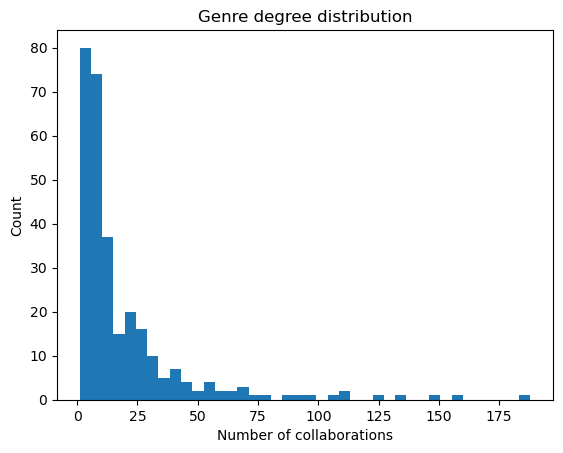

In [13]:

plt.hist(degrees, bins=40)
plt.title("Genre degree distribution")
plt.xlabel("Number of collaborations")
plt.ylabel("Count")
plt.show()


Weighted Degree Distribution 

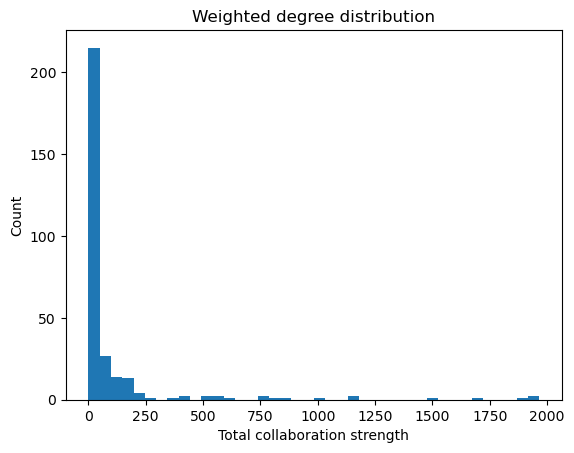

In [14]:
weighted_degree = [d for _,d in G.degree(weight="weight")]

plt.hist(weighted_degree, bins=40)
plt.title("Weighted degree distribution")
plt.xlabel("Total collaboration strength")
plt.ylabel("Count")
plt.show()


Success Distribution

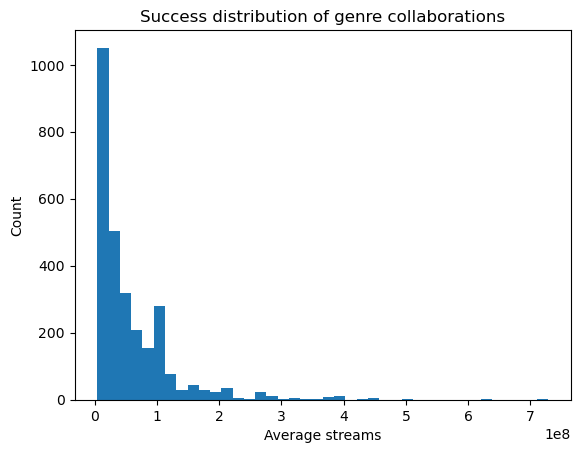

In [15]:
plt.hist(streams, bins=40)
plt.title("Success distribution of genre collaborations")
plt.xlabel("Average streams")
plt.ylabel("Count")
plt.show()


Collaboration weight distribution

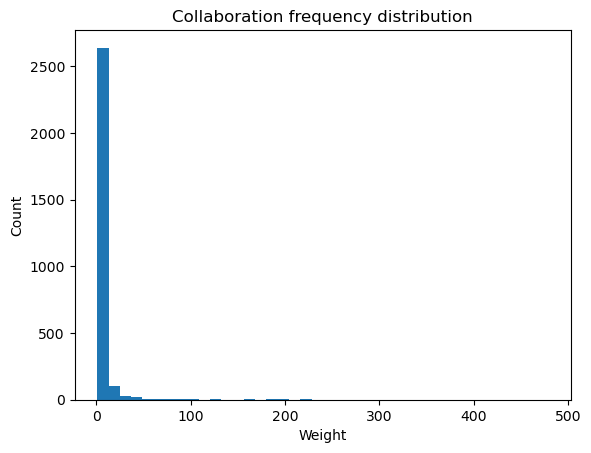

In [16]:
plt.hist(weights, bins=40)
plt.title("Collaboration frequency distribution")
plt.xlabel("Weight")
plt.ylabel("Count")
plt.show()


### Network Visualization

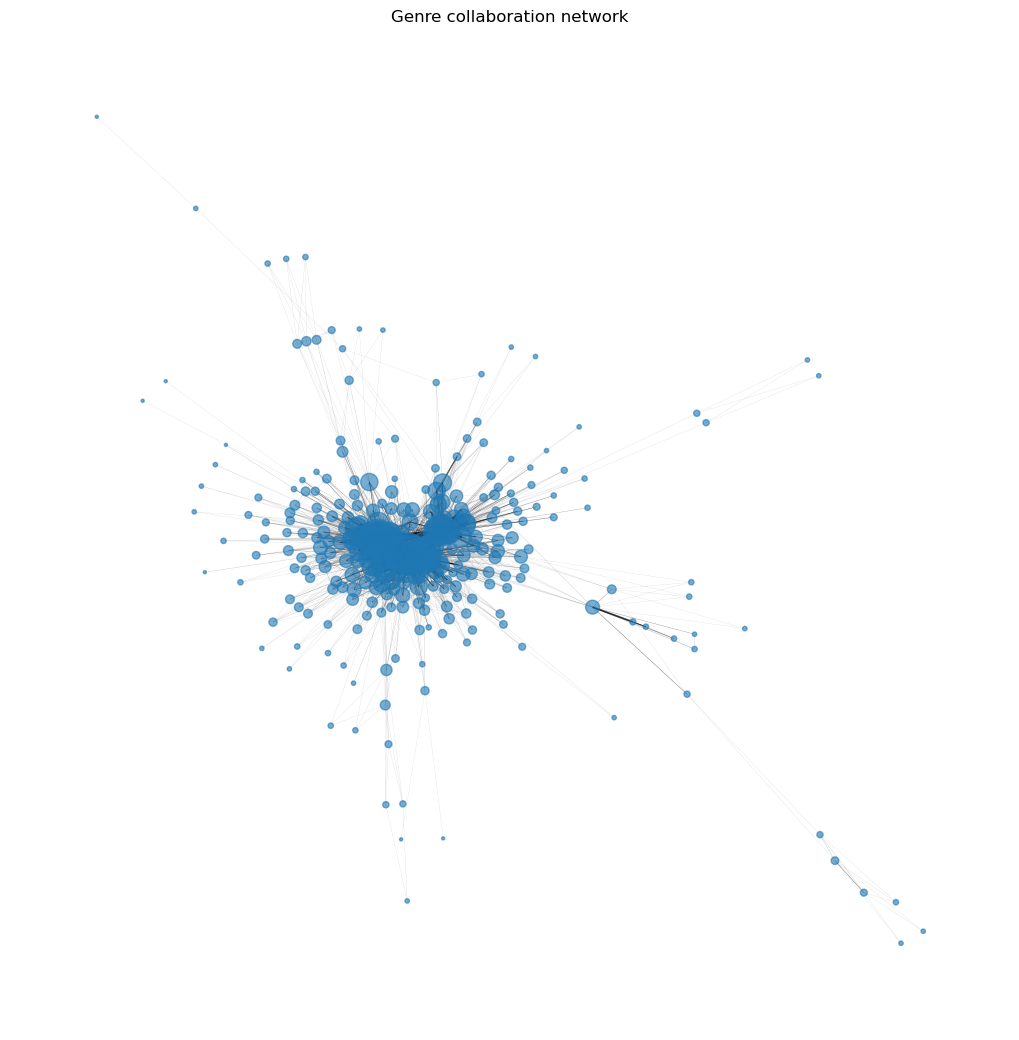

In [17]:
plt.figure(figsize=(10,10))

pos = nx.spring_layout(G, seed=42)

node_sizes = [G.degree(n)*5 for n in G.nodes()]
edge_widths = [G[u][v]["weight"]/20 for u,v in G.edges()]

nx.draw(
    G,
    pos,
    node_size=node_sizes,
    width=edge_widths,
    with_labels=False,
    alpha=0.6
)

plt.title("Genre collaboration network")
plt.show()


#### Top hubs (genres with highest degree)

In [18]:
sorted(G.degree, key=lambda x: x[1], reverse=True)[:10]


[('pop', 188),
 ('dance pop', 159),
 ('pop rap', 150),
 ('post-teen pop', 135),
 ('rap', 123),
 ('tropical house', 110),
 ('edm', 110),
 ('trap', 104),
 ('latin', 96),
 ('reggaeton', 91)]

#### Top collaborations by weight

In [19]:
sorted(G.edges(data=True), key=lambda x: x[2]["weight"], reverse=True)[:10]


[('latin', 'reggaeton', {'weight': 479, 'avg_streams': 106046838.22727272}),
 ('pop rap', 'rap', {'weight': 222, 'avg_streams': 53856301.00917431}),
 ('rap', 'trap', {'weight': 218, 'avg_streams': 66562200.67326733}),
 ('rap', 'hip hop', {'weight': 203, 'avg_streams': 54050063.56790123}),
 ('latin', 'tropical', {'weight': 195, 'avg_streams': 107063300.45614035}),
 ('latin', 'trap latino', {'weight': 187, 'avg_streams': 119762208.56666666}),
 ('dance pop', 'pop', {'weight': 183, 'avg_streams': 86030063.95}),
 ('latin',
  'reggaeton flow',
  {'weight': 178, 'avg_streams': 109168794.71428572}),
 ('reggaeton', 'tropical', {'weight': 166, 'avg_streams': 97913663.48}),
 ('reggaeton',
  'trap latino',
  {'weight': 165, 'avg_streams': 117973323.73214284})]

Top collaborations by success

In [20]:
sorted(G.edges(data=True), key=lambda x: x[2]["avg_streams"], reverse=True)[:10]


[('pop', 'hollywood', {'weight': 1, 'avg_streams': 728673266.0}),
 ('progressive electro house',
  'pop rock',
  {'weight': 1, 'avg_streams': 634161629.0}),
 ('brostep', 'pop rock', {'weight': 1, 'avg_streams': 634161629.0}),
 ('gangster rap', 'dfw rap', {'weight': 1, 'avg_streams': 505537957.0}),
 ('progressive electro house',
  'metropopolis',
  {'weight': 2, 'avg_streams': 454133585.5}),
 ('brostep', 'metropopolis', {'weight': 2, 'avg_streams': 454133585.5}),
 ('post-teen pop', 'etherpop', {'weight': 1, 'avg_streams': 442077913.0}),
 ('alternative r&b', 'etherpop', {'weight': 1, 'avg_streams': 442077913.0}),
 ('alternative r&b',
  'indie poptimism',
  {'weight': 1, 'avg_streams': 442077913.0}),
 ('hip hop', 'philly rap', {'weight': 1, 'avg_streams': 436803605.0})]

it means that collaboration frequency is not equal to popularity

### Statistical testing

Statistical testing is postponed at this stage because the current network distances are not informative: directly collaborating genres all have shortest-path distance equal to 1, producing almost no variation in the predictor variable. Meaningful correlation or regression analysis therefore requires embedding the network first, so that continuous genre distances can be computed and tested against collaboration success.

Preparing data for testing

In [21]:
distances = []
success = []

for u, v, d in G.edges(data=True):
    
    # shortest path distance between genres
    try:
        dist = nx.shortest_path_length(G, u, v)
    except:
        continue
    
    distances.append(dist)
    success.append(d["avg_streams"])

##### Coorelation test

In [23]:
corr, p = spearmanr(distances, success)

print("Spearman correlation:", corr)
print("p-value:", p)


Spearman correlation: nan
p-value: nan


/var/folders/4x/l0sbrhlx0kx4f0hwzx7x2yqr0000gn/T/ipykernel_2973/230738852.py:1: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p = spearmanr(distances, success)


Regression Model

In [26]:

X = sm.add_constant(distances)
model = sm.OLS(np.log1p(success), X).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 17 Feb 2026   Prob (F-statistic):                nan
Time:                        14:19:55   Log-Likelihood:                -4435.3
No. Observations:                2833   AIC:                             8873.
Df Residuals:                    2832   BIC:                             8879.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.2531      0.022    792.911      0.0

Plot Relationship

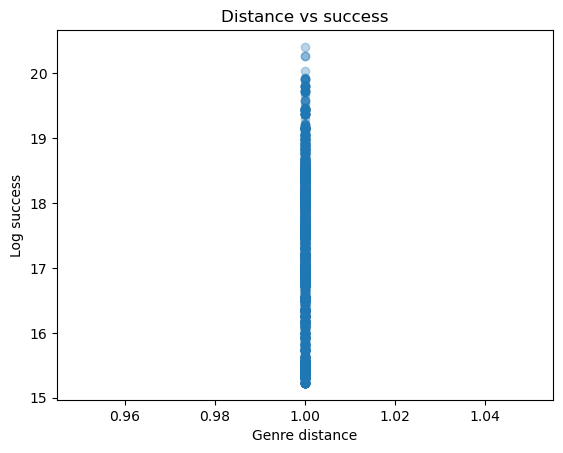

In [27]:
plt.scatter(distances, np.log1p(success), alpha=0.3)
plt.xlabel("Genre distance")
plt.ylabel("Log success")
plt.title("Distance vs success")
plt.show()